In [ ]:
import torch
import pandas as pd
import unicodedata
import networkx as nx
import numpy as np
from torch_geometric.utils import from_networkx
from torch_geometric.nn import Node2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import random
import pathlib

data_fp = '../data/PROCESSED/'
model_fp = '../models/' 

#if  models is not a directory
pathlib.Path(model_fp).mkdir(parents=True, exist_ok=True)

# Load Data
df = pd.read_csv(f"{data_fp}/filtered_primekg.csv",
                 dtype={"x_name": str, "y_name": str, "relation": str, "x_type": str, "y_type": str},
                 low_memory=False)

print(f"[INFO] Data Loaded: {df.shape[0]} rows")

# Normalize Text Formatting
def clean_text(text):
    return unicodedata.normalize("NFKD", str(text)).strip().lower()

df["x_name"] = df["x_name"].apply(clean_text)
df["y_name"] = df["y_name"].apply(clean_text)

# Fix Node Type Mapping
node_type_mapping = {
    "gene/protein": "protein",
    "chemical/drug": "drug",
    "drug": "drug",
    "disease": "disease",
    "biological_process": "bioprocess",
    "bioprocess": "bioprocess",
    "pathway": "pathway",
    "effect/phenotype": "phenotype"
}

df["x_type"] = df["x_type"].map(node_type_mapping)
df["y_type"] = df["y_type"].map(node_type_mapping)
# Print Unique Relationships and Their Counts
print("\n [INFO] Relationship Counts:")
relation_counts = df["relation"].value_counts()
for relation, count in relation_counts.items():
    print(f"   {relation}: {count} edges") 

/home/agrima/miniconda3/envs/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[INFO] Data Loaded: 1846056 rows

 [INFO] Relationship Counts:
   protein_protein: 642150 edges
   disease_phenotype_positive: 300634 edges
   bioprocess_protein: 289610 edges
   disease_protein: 160822 edges
   drug_effect: 129568 edges
   pathway_protein: 85292 edges
   disease_disease: 64388 edges
   contraindication: 61350 edges
   drug_protein: 51306 edges
   anatomy_protein_absent: 39774 edges
   indication: 18776 edges
   disease_phenotype_negative: 2386 edges


In [ ]:
# ---- Extract Unique Node Names ----
all_nodes = pd.concat([df["x_name"], df["y_name"]]).dropna().unique()
node_maps = {name: i for i, name in enumerate(sorted(all_nodes))}  
#logging
print(f"[INFO] Total unique nodes: {len(node_maps):,}")

# ---- Construct Normalized Relation Map ----
relation_map = {}

for rel in df["relation"].unique():
    subset = df[df["relation"] == rel]
    if subset.empty:
        continue

    type_pairs = set(zip(subset["x_type"], subset["y_type"]))

    for x_type, y_type in type_pairs:
        if x_type in node_type_mapping.values() and y_type in node_type_mapping.values():
            normalized_pair = tuple(sorted([x_type, y_type]))
            relation_map[rel] = normalized_pair

print(f"[INFO] Total unique normalized relations: {len(relation_map):,}")


[INFO] Total unique nodes: 69,092
[INFO] Total unique normalized relations: 11


In [3]:
# ---- Build Graph with Global Node Map ----
G = nx.Graph()

for rel in relation_map:
    rel_df = df[df['relation'] == rel]
    src_indices = rel_df['x_name'].map(node_maps).fillna(-1).astype(int)
    dst_indices = rel_df['y_name'].map(node_maps).fillna(-1).astype(int)

    valid_edges = [(s, d) for s, d in zip(src_indices, dst_indices) if s != -1 and d != -1]
    G.add_edges_from(valid_edges)

print("\n[INFO] Graph constructed successfully with global node map.")



[INFO] Graph constructed successfully with global node map.


In [4]:
# Step 1: Create a DataFrame with node_name, node_type, and global_id
node_df = pd.concat([
    df[["x_name", "x_type"]].rename(columns={"x_name": "node_name", "x_type": "node_type"}),
    df[["y_name", "y_type"]].rename(columns={"y_name": "node_name", "y_type": "node_type"})
]).dropna().drop_duplicates().reset_index(drop=True)

# Step 2: Add global ID from node_maps
node_df["global_id"] = node_df["node_name"].map(node_maps)


In [5]:
# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Convert NetworkX Graph to PyG format ---
pyg_graph = from_networkx(G)
pyg_graph.edge_index = pyg_graph.edge_index.to(device)

# --- Initialize Node2Vec ---
node2vec = Node2Vec(
    edge_index=pyg_graph.edge_index,
    embedding_dim=128,
    walk_length=10,
    context_size=5,
    walks_per_node=20,
    num_negative_samples=1
).to(device)

# Make sure necessary attributes are on the correct device
node2vec.rowptr = node2vec.rowptr.to(device)
node2vec.col = node2vec.col.to(device)

# --- Hyperparameters ---
batch_size = 256
patience = 200
epochs_no_improve = 0
best_loss = float("inf")

# --- Prepare Edge Splits for Evaluation ---
edge_index = pyg_graph.edge_index
num_edges = edge_index.size(1)
train_indices, val_indices = train_test_split(np.arange(num_edges), test_size=0.1, random_state=42)

train_indices = torch.tensor(train_indices, device=device)
val_indices = torch.tensor(val_indices, device=device)

optimizer = torch.optim.Adam(node2vec.parameters(), lr=0.0025)

print("[INFO] Starting Node2Vec training with edge sampling...")

# --- Training Loop ---
for epoch in range(1, 10001):
    optimizer.zero_grad()

    batch_idx = train_indices[torch.randint(0, train_indices.size(0), (batch_size,), device=device)]
    batch_nodes = edge_index[:, batch_idx].reshape(-1).unique()

    pos_rw = node2vec.pos_sample(batch_nodes)
    neg_rw = node2vec.neg_sample(batch_nodes)

    loss = node2vec.loss(pos_rw, neg_rw)
    loss.backward()
    optimizer.step()

    # --- Validation ---
    node2vec.eval()
    with torch.no_grad():
        val_batch_idx = val_indices[torch.randint(0, val_indices.size(0), (batch_size,), device=device)]
        val_batch_nodes = edge_index[:, val_batch_idx].reshape(-1).unique()

        val_pos_rw = node2vec.pos_sample(val_batch_nodes)
        val_neg_rw = node2vec.neg_sample(val_batch_nodes)
        val_loss = node2vec.loss(val_pos_rw, val_neg_rw)

    print(f"Epoch {epoch:04d}: Train Loss = {loss.item():.4f} | Val Loss = {val_loss.item():.4f}")

    # --- Early Stopping ---
    if val_loss.item() < best_loss:
        best_loss = val_loss.item()
        torch.save(node2vec.embedding.weight.data.clone().cpu(), f"{model_fp}/best_node2vec_embeddings.pt")
        print(f"[INFO]  New Best Loss: {best_loss:.4f} → Saved embeddings.")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"[INFO]  Early stopping after {epoch} epochs.")
        break

print("\n[INFO] Node2Vec embedding training completed successfully!")


[INFO] Starting Node2Vec training with edge sampling...
Epoch 0001: Train Loss = 9.9297 | Val Loss = 9.9545
[INFO]  New Best Loss: 9.9545 → Saved embeddings.
Epoch 0002: Train Loss = 10.0248 | Val Loss = 9.8972
[INFO]  New Best Loss: 9.8972 → Saved embeddings.
Epoch 0003: Train Loss = 9.9229 | Val Loss = 9.9535
Epoch 0004: Train Loss = 9.9193 | Val Loss = 9.9269
Epoch 0005: Train Loss = 9.9190 | Val Loss = 9.8916
[INFO]  New Best Loss: 9.8916 → Saved embeddings.
Epoch 0006: Train Loss = 9.8855 | Val Loss = 9.9247
Epoch 0007: Train Loss = 9.8962 | Val Loss = 9.8921
Epoch 0008: Train Loss = 9.8944 | Val Loss = 9.8920
Epoch 0009: Train Loss = 9.9155 | Val Loss = 9.8999
Epoch 0010: Train Loss = 9.8130 | Val Loss = 9.8773
[INFO]  New Best Loss: 9.8773 → Saved embeddings.
Epoch 0011: Train Loss = 9.8510 | Val Loss = 9.8428
[INFO]  New Best Loss: 9.8428 → Saved embeddings.
Epoch 0012: Train Loss = 9.8783 | Val Loss = 9.8144
[INFO]  New Best Loss: 9.8144 → Saved embeddings.
Epoch 0013: Train L

# Logistic Regression

In [8]:
embeddings = torch.load(f"{model_fp}/best_node2vec_embeddings.pt").to(device)

def evaluate_link_prediction(relation_name, src_type, tgt_type, node1_name, node2_name, top_k=10):
    print(f"\n[INFO] Evaluating {src_type.title()} ↔ {tgt_type.title()} for relation: {relation_name}")

    # Step 1: Get positive edges for the relation
    relation_edges = np.sort(
        df[df["relation"] == relation_name][["x_name", "y_name"]].values.astype("U"),
        axis=1
    )
    relation_edges = np.unique(relation_edges, axis=0)

    # Step 2: Get valid node lists for each type
    src_nodes = list(node_df[node_df["node_type"] == src_type]["node_name"])
    tgt_nodes = list(node_df[node_df["node_type"] == tgt_type]["node_name"])

    embedding_size = embeddings.shape[0]
    pos_edges = np.array([
        [node_maps[x], node_maps[y]]
        for x, y in relation_edges
        if x in node_maps and y in node_maps
        and node_maps[x] < embedding_size and node_maps[y] < embedding_size
    ])


    if len(pos_edges) == 0:
        print("[ERROR] No valid positive edges found. Check relation or node types.")
        return

    # Step 4: Sample negatives once, of the same size
    num_samples = len(pos_edges)
    neg_edges = []
    while len(neg_edges) < num_samples:
        x = random.choice(src_nodes)
        y = random.choice(tgt_nodes)
        if x in node_maps and y in node_maps:
            xi = node_maps[x]
            yi = node_maps[y]
            if xi < embedding_size and yi < embedding_size:
                neg_edges.append([xi, yi])
    neg_edges = np.array(neg_edges)


    # Step 5: Split positives and negatives into train/test separately
    pos_train, pos_test = train_test_split(pos_edges, test_size=0.2, random_state=42)
    neg_train, neg_test = train_test_split(neg_edges, test_size=0.2, random_state=42)

    # Step 6: Compute features using dot product (u · v)
    def edge_features(edges):
        return (embeddings[edges[:, 0]] * embeddings[edges[:, 1]]).sum(dim=1).view(-1, 1)

    X_train = torch.cat([edge_features(pos_train), edge_features(neg_train)], dim=0).cpu().numpy()

    y_train = np.array([1] * len(pos_train) + [0] * len(neg_train))

    X_test = torch.cat([edge_features(pos_test), edge_features(neg_test)], dim=0).cpu().numpy()
    y_test = np.array([1] * len(pos_test) + [0] * len(neg_test))

    # Step 7: Train logistic regression
    model = LogisticRegression(class_weight="balanced", max_iter=1000)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]

    # Step 8: Evaluation metrics
    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    roc_auc = roc_auc_score(y_test, probs)

    print("\n[INFO] Evaluation Metrics:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")

    # Step 9: Top-k highest scoring negative edges (for inspection)
    print(f"\n[INFO] Top-{top_k} Predicted {src_type.title()} ↔ {tgt_type.title()} Links:")
    top_indices = np.argsort(probs)[-top_k:]
    test_neg_only = neg_test[:len(probs)]  # safeguard
    for idx in top_indices:
        if idx < len(test_neg_only):
            u_idx, v_idx = test_neg_only[idx]
            u_name = next((k for k, v in node_maps.items() if v == u_idx), "UNKNOWN")
            v_name = next((k for k, v in node_maps.items() if v == v_idx), "UNKNOWN")
            print(f"{u_name} ↔ {v_name} (score: {probs[idx]:.4f})")

    # Step 10: Score user-defined node pair
    print(f"\nScoring: \"{node1_name}\" ↔ \"{node2_name}\"")
    if node1_name in node_maps and node2_name in node_maps:
        u = node_maps[node1_name]
        v = node_maps[node2_name]
        pair_feat = (embeddings[u] * embeddings[v]).sum().item()
        pair_score = model.predict_proba(np.array([[pair_feat]]))[:, 1][0]
        print(f"Predicted probability: {pair_score:.4f}")
    else:
        print("One or both nodes not found in node maps.")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "roc_auc": roc_auc,
    }



/tmp/ipykernel_15744/413644491.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings = torch.load(f"{model_fp}/best_node2vec_embeddings.pt").to(device)


In [9]:
evaluate_link_prediction(
    relation_name="disease_phenotype_positive",
    src_type="disease",
    tgt_type="phenotype",
    node1_name="permanent neonatal diabetes mellitus",
    node2_name="retinopathy"
)



[INFO] Evaluating Disease ↔ Phenotype for relation: disease_phenotype_positive

[INFO] Evaluation Metrics:
Accuracy:  0.5031
Precision: 0.5036
Recall:    0.4368
F1 Score:  0.4678
ROC-AUC:   0.5040

[INFO] Top-10 Predicted Disease ↔ Phenotype Links:
meningitis (disease) ↔ premature loss of permanent teeth (score: 0.5335)
pressure-induced localized lipoatrophy ↔ elevated circulating globotriaosylceramide concentration (score: 0.5349)
disseminated intravascular coagulation ↔ streaks of hyperkeratosis along each finger onto the palm (score: 0.5376)
cone dystrophy with supernormal rod response ↔ elevated circulating palmitoleylcarnitine concentration (score: 0.5379)
budd-chiari syndrome ↔ 2-3 toe syndactyly (score: 0.5384)
small intestinal intraepithelial neoplasia ↔ alopecia totalis (score: 0.5401)
benign neoplasm of cerebrum ↔ abnormal saccadic eye movements (score: 0.5411)
slti-salem syndrome ↔ choroid plexus papilloma (score: 0.5448)

Scoring: "permanent neonatal diabetes mellitus" ↔ "

{'accuracy': 0.5031169783645031,
 'precision': 0.5035935278066028,
 'recall': 0.4368103477014368,
 'f1_score': 0.46783061982290775,
 'roc_auc': 0.5039551104269787}

# XGBoost

In [10]:
def evaluate_with_xgboost(relation_name, src_type, tgt_type, node1_name, node2_name, top_k=10):
    print(f"\n[INFO] Evaluating {src_type.title()} ↔ {tgt_type.title()} with XGBoost for relation: {relation_name}")

    # Step 1: Get positive edges for the relation
    relation_edges = np.sort(
        df[df["relation"] == relation_name][["x_name", "y_name"]].values.astype("U"),
        axis=1
    )
    relation_edges = np.unique(relation_edges, axis=0)

    # Step 2: Get node names for the types
    src_nodes = list(node_df[node_df["node_type"] == src_type]["node_name"])
    tgt_nodes = list(node_df[node_df["node_type"] == tgt_type]["node_name"])

    # Step 3: Construct valid positive edge index pairs
    embedding_size = embeddings.shape[0]
    pos_edges = np.array([
        [node_maps[x], node_maps[y]]
        for x, y in relation_edges
        if x in node_maps and y in node_maps
        and node_maps[x] < embedding_size and node_maps[y] < embedding_size
    ])


    if len(pos_edges) == 0:
        print("[ERROR] No valid positive edges found. Check relation or node types.")
        return

    # Step 4: Sample negatives once, of the same size
    num_samples = len(pos_edges)
    neg_edges = []
    while len(neg_edges) < num_samples:
        x = random.choice(src_nodes)
        y = random.choice(tgt_nodes)
        if x in node_maps and y in node_maps:
            xi = node_maps[x]
            yi = node_maps[y]
            if xi < embedding_size and yi < embedding_size:
                neg_edges.append([xi, yi])
    neg_edges = np.array(neg_edges)

    # Step 5: Split pos/neg edges into train/test
    pos_train, pos_test = train_test_split(pos_edges, test_size=0.2, random_state=42)
    neg_train, neg_test = train_test_split(neg_edges, test_size=0.2, random_state=42)

    # Step 6: Define embedding concatenation
    def concat_features(edge_array):
        return torch.cat([
            embeddings[edge_array[:, 0]],
            embeddings[edge_array[:, 1]]
        ], dim=1)

    X_train = torch.cat([concat_features(pos_train), concat_features(neg_train)], dim=0).cpu().numpy()
    y_train = np.array([1] * len(pos_train) + [0] * len(neg_train))

    X_test = torch.cat([concat_features(pos_test), concat_features(neg_test)], dim=0).cpu().numpy()
    y_test = np.array([1] * len(pos_test) + [0] * len(neg_test))

    # Step 7: Train XGBoost model
    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        use_label_encoder=False,
        n_estimators=200,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        verbosity=0
    )
    model.fit(X_train, y_train)

    # Step 8: Evaluate
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    roc_auc = roc_auc_score(y_test, probs)

    print("\n[INFO] XGBoost Prediction Metrics:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")

    # Step 9: Score a specific user-defined pair
    print(f"\nScoring: \"{node1_name}\" ↔ \"{node2_name}\"")
    if node1_name in node_maps and node2_name in node_maps:
        u = node_maps[node1_name]
        v = node_maps[node2_name]
        pair_feat = torch.cat([embeddings[u], embeddings[v]]).cpu().numpy().reshape(1, -1)
        score = model.predict_proba(pair_feat)[:, 1][0]
        print(f"Predicted probability: {score:.4f}")
    else:
        print("One or both nodes not found in node mappings.")

    # Step 10: Show top-k predicted negative links
    print(f"\nSample Predicted {src_type.title()} ↔ {tgt_type.title()} Links (XGBoost):")
    top_indices = np.argsort(probs)[-top_k:]
    test_neg_only = neg_test[:len(probs)]  # safeguard
    for idx in top_indices:
        if idx < len(test_neg_only):
            u_idx, v_idx = test_neg_only[idx]
            u_name = next((k for k, v in node_maps.items() if v == u_idx), "UNKNOWN")
            v_name = next((k for k, v in node_maps.items() if v == v_idx), "UNKNOWN")
            print(f"{u_name} ↔ {v_name} (score: {probs[idx]:.4f})")

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "roc_auc": roc_auc,
    }


In [11]:
evaluate_with_xgboost(
    relation_name="disease_phenotype_positive",
    src_type="disease",
    tgt_type="phenotype",
    node1_name="permanent neonatal diabetes mellitus",
    node2_name="retinopathy"
)



[INFO] Evaluating Disease ↔ Phenotype with XGBoost for relation: disease_phenotype_positive

[INFO] XGBoost Prediction Metrics:
Accuracy:  0.7938
Precision: 0.7906
Recall:    0.7992
F1 Score:  0.7949
ROC-AUC:   0.8800

Scoring: "permanent neonatal diabetes mellitus" ↔ "retinopathy"
Predicted probability: 0.3672

Sample Predicted Disease ↔ Phenotype Links (XGBoost):
cervical polyp (disease) ↔ abnormality of thumb phalanx (score: 0.9753)
dieulafoy lesion ↔ cerebellar hypoplasia (score: 0.9762)
pregnancy loss, recurrent, susceptibility to ↔ intracranial meningioma (score: 0.9769)
renal tubular acidosis, distal, 4, with hemolytic anemia ↔ decreased head circumference (score: 0.9770)
alexia ↔ autosomal dominant contiguous gene syndrome (score: 0.9774)
hypertriglyceridemia (disease) ↔ congenital peripheral neuropathy (score: 0.9808)
partial deletion of the short arm of chromosome 12 ↔ tiger tail banding (score: 0.9811)
congenital lactase deficiency ↔ areolar fullness (score: 0.9842)
chromos

{'accuracy': 0.7937960462712937,
 'precision': 0.7906278855032317,
 'recall': 0.7992465913257992,
 'f1_score': 0.7949138774224566,
 'roc_auc': 0.8800137511723193}

# RFC

In [12]:
def evaluate_with_rfc(relation_name, src_type, tgt_type, node1_name, node2_name, top_k=10):
    print(f"\n[INFO] Evaluating {src_type.title()} ↔ {tgt_type.title()} with Random Forest for relation: {relation_name}")

    # Step 1: Get positive edges for the relation
    relation_edges = np.sort(
        df[df["relation"] == relation_name][["x_name", "y_name"]].values.astype("U"),
        axis=1
    )
    relation_edges = np.unique(relation_edges, axis=0)

    # Step 2: Get node names for the types
    src_nodes = list(node_df[node_df["node_type"] == src_type]["node_name"])
    tgt_nodes = list(node_df[node_df["node_type"] == tgt_type]["node_name"])

    # Step 3: Construct valid positive edge index pairs
    embedding_size = embeddings.shape[0]
    pos_edges = np.array([
        [node_maps[x], node_maps[y]]
        for x, y in relation_edges
        if x in node_maps and y in node_maps
        and node_maps[x] < embedding_size and node_maps[y] < embedding_size
    ])


    if len(pos_edges) == 0:
        print("[ERROR] No valid positive edges found. Check relation or node types.")
        return

    # Step 4: Sample negatives once, of the same size
    num_samples = len(pos_edges)
    neg_edges = []
    while len(neg_edges) < num_samples:
        x = random.choice(src_nodes)
        y = random.choice(tgt_nodes)
        if x in node_maps and y in node_maps:
            xi = node_maps[x]
            yi = node_maps[y]
            if xi < embedding_size and yi < embedding_size:
                neg_edges.append([xi, yi])
    neg_edges = np.array(neg_edges)

    # Step 5: Split pos/neg edges into train/test
    pos_train, pos_test = train_test_split(pos_edges, test_size=0.2, random_state=42)
    neg_train, neg_test = train_test_split(neg_edges, test_size=0.2, random_state=42)

    # Step 6: Define embedding concatenation
    def concat_features(edge_array):
        return torch.cat([
            embeddings[edge_array[:, 0]],
            embeddings[edge_array[:, 1]]
        ], dim=1)

    X_train = torch.cat([concat_features(pos_train), concat_features(neg_train)], dim=0).cpu().numpy()
    y_train = np.array([1] * len(pos_train) + [0] * len(neg_train))

    X_test = torch.cat([concat_features(pos_test), concat_features(neg_test)], dim=0).cpu().numpy()
    y_test = np.array([1] * len(pos_test) + [0] * len(neg_test))

    # Step 7: Train Random Forest model
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    # Step 8: Evaluate
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    roc_auc = roc_auc_score(y_test, probs)

    print("\n[INFO] Random Forest Prediction Metrics:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")

    # Step 9: Score a specific user-defined pair
    print(f"\nScoring: \"{node1_name}\" ↔ \"{node2_name}\"")
    if node1_name in node_maps and node2_name in node_maps:
        u = node_maps[node1_name]
        v = node_maps[node2_name]
        pair_feat = torch.cat([embeddings[u], embeddings[v]]).cpu().numpy().reshape(1, -1)
        score = model.predict_proba(pair_feat)[:, 1][0]
        print(f"Predicted probability: {score:.4f}")
    else:
        print("One or both nodes not found in node mappings.")

    # Step 10: Show top-k predicted negative links
    print(f"\nSample Predicted {src_type.title()} ↔ {tgt_type.title()} Links (Random Forest):")
    top_indices = np.argsort(probs)[-top_k:]
    test_neg_only = neg_test[:len(probs)]
    for idx in top_indices:
        if idx < len(test_neg_only):
            u_idx, v_idx = test_neg_only[idx]
            u_name = next((k for k, v in node_maps.items() if v == u_idx), "UNKNOWN")
            v_name = next((k for k, v in node_maps.items() if v == v_idx), "UNKNOWN")
            print(f"{u_name} ↔ {v_name} (score: {probs[idx]:.4f})")

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "roc_auc": roc_auc,
    }


In [13]:
evaluate_with_rfc(
    relation_name="disease_phenotype_positive",
    src_type="disease",
    tgt_type="phenotype",
    node1_name="permanent neonatal diabetes mellitus",
    node2_name="retinopathy"
)


[INFO] Evaluating Disease ↔ Phenotype with Random Forest for relation: disease_phenotype_positive

[INFO] Random Forest Prediction Metrics:
Accuracy:  0.8218
Precision: 0.8110
Recall:    0.8392
F1 Score:  0.8249
ROC-AUC:   0.9008

Scoring: "permanent neonatal diabetes mellitus" ↔ "retinopathy"
Predicted probability: 0.4715

Sample Predicted Disease ↔ Phenotype Links (Random Forest):
aplasia of lacrimal and salivary glands ↔ steatocystoma multiplex (score: 0.9915)
3-hydroxy-3-methylglutaryl-coa synthase deficiency ↔ band-shaped corneal dystrophy (score: 0.9917)
gastric antral vascular ectasia ↔ conjunctival amyloidosis (score: 0.9922)
neurocutaneous syndrome ↔ progressive hyperpigmentation (score: 0.9923)
acute generalized exanthematous pustulosis ↔ t2 hypointense basal ganglia (score: 0.9924)
susceptibility to mononeuropathy of the median nerve, mild ↔ abnormal adipose tissue morphology (score: 0.9924)
congenital renal artery stenosis ↔ neck muscle weakness (score: 0.9925)
parasagitta

{'accuracy': 0.8218155148848219,
 'precision': 0.811031994071592,
 'recall': 0.8391505817248391,
 'f1_score': 0.8248517219910214,
 'roc_auc': 0.9007789545609004}

In [14]:
def plot_embedding_projection(embeddings, labels, method="tsne", title="Embedding Projection"):
    """
    Projects node embeddings into 2D space using t-SNE and visualizes them with enhanced colors.

    Parameters:
    - embeddings: numpy array or torch.Tensor
    - labels: list of categorical labels (e.g., node types)
    - method: 'tsne' or 'pca'
    - title: plot title
    """
    if method == "tsne":
        reducer = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    elif method == "pca":
        reducer = PCA(n_components=2)
    else:
        raise ValueError("Choose method as 'tsne' or 'pca'")

    if hasattr(embeddings, "cpu"):  # For torch.Tensor
        embeddings = embeddings.cpu().detach().numpy()

    reduced = reducer.fit_transform(embeddings)
    df = pd.DataFrame(reduced, columns=["x", "y"])
    df["label"] = labels

    plt.figure(figsize=(9, 7))
    pastel_palette = sns.color_palette("Set2")  # Better for categorical groups

    sns.scatterplot(
        data=df, x="x", y="y", hue="label",
        palette=pastel_palette, s=40, alpha=0.85, edgecolor="white", linewidth=0.4
    )

    plt.xlabel("Component 1", fontsize=12)
    plt.ylabel("Component 2", fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(title="Node Type", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# 5. Top-k Predicted Links

def show_topk_predicted_links(model, embeddings, node_maps, neg_edges, top_k=10):
    """
    Shows top-k highest scoring negative edges predicted as positive links.
    Assumes `node_maps` is flat: {node_name: global_index}
    """

    probs = model.predict_proba(
        torch.cat([
            embeddings[neg_edges[:, 0]],
            embeddings[neg_edges[:, 1]]
        ], dim=1).numpy()
    )[:, 1]

    top_indices = np.argsort(probs)[-top_k:]
    print(f"\nTop-{top_k} Predicted Links:")
    for idx in top_indices:
        u, v = neg_edges[idx]

        u_name = next((k for k, val in node_maps.items() if val == u), "UNKNOWN")
        v_name = next((k for k, val in node_maps.items() if val == v), "UNKNOWN")

        print(f"{u_name} ↔ {v_name} (score: {probs[idx]:.4f})")

def plot_similarity_heatmap(embeddings, selected_nodes, node_maps, title="Cosine Similarity Heatmap"):
    """
    Plots a cosine similarity heatmap between selected nodes.
    Assumes `node_maps` is flat and contains node_name → global_index.
    """
    # Filter valid nodes that exist in node_maps
    valid_nodes = [n for n in selected_nodes if n in node_maps]
    missing_nodes = [n for n in selected_nodes if n not in node_maps]

    if missing_nodes:
        print(f"[WARNING] These nodes were skipped (not found in node_maps): {missing_nodes}")

    indices = [node_maps[n] for n in valid_nodes]
    selected_embeds = embeddings[indices]

    sim_matrix = torch.nn.functional.cosine_similarity(
        selected_embeds.unsqueeze(1), selected_embeds.unsqueeze(0), dim=2
    ).detach().numpy()

    df = pd.DataFrame(sim_matrix, index=valid_nodes, columns=valid_nodes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(df, annot=True, cmap="viridis", square=True, fmt=".2f")
    plt.title(title)
    plt.tight_layout()
    plt.show()



/home/agrima/miniconda3/envs/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/tmp/ipykernel_15744/2010537738.py:28: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  sns.scatterplot(


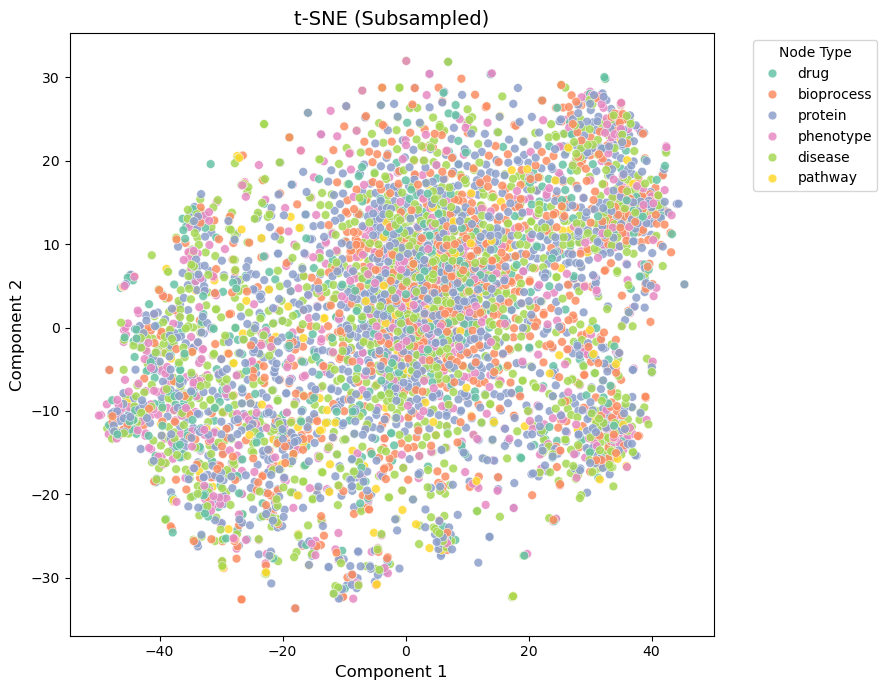

In [15]:
# Create a list of node types aligned with embedding indices
labels = [None] * embeddings.shape[0]
for _, row in node_df.iterrows():
    idx = row["global_id"]
    if 0 <= idx < len(labels):
        labels[idx] = row["node_type"]


max_samples = 5000
indices = np.random.choice(len(labels), size=min(max_samples, len(labels)), replace=False)
sampled_embeddings = embeddings[indices]
sampled_labels = [labels[i] for i in indices]

plot_embedding_projection(sampled_embeddings, sampled_labels, method="tsne", title="t-SNE (Subsampled)")

[WARNING] These nodes were skipped (not found in node_maps): ['diabetes', 'obesity']


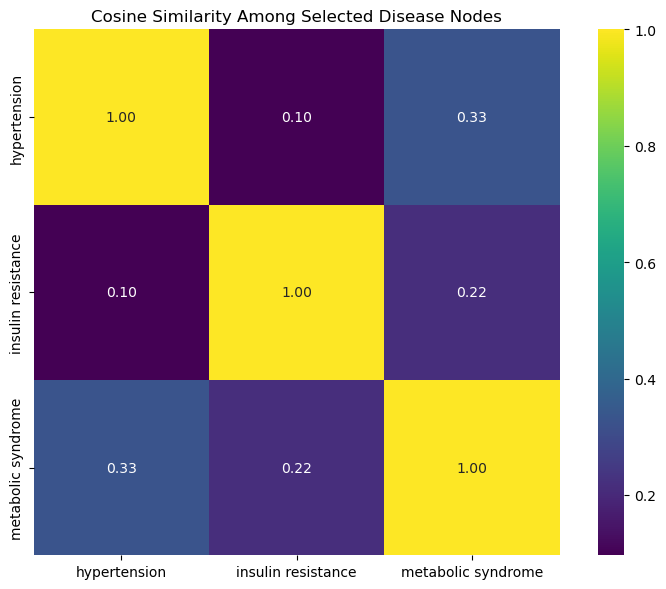

In [16]:
selected_nodes = [
    "diabetes",
    "hypertension",
    "insulin resistance",
    "metabolic syndrome",
    "obesity"
]

plot_similarity_heatmap(
    embeddings=embeddings,
    selected_nodes=selected_nodes,
    node_maps=node_maps,  # flat dict: {name → global_id}
    title="Cosine Similarity Among Selected Disease Nodes"
)
